# Tutorial 12: Autoregressive Image Modeling

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial12/Autoregressive_Image_Modeling.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial12/Autoregressive_Image_Modeling.ipynb)     
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial12)   
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial12/Autoregressive_Image_Modeling.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code.
    
</div>

---

**Speed comparison**: We note the training times for all models in the PyTorch and the JAX implementation below (PyTorch v1.11, JAX v0.3.13). The models were trained on the same hardware (NVIDIA RTX3090, 24 core CPU) and we slightly adjusted the tutorials to use the exact same training settings (200 epochs, data loading parameters, evaluation schedule, etc.). Overall, the JAX implementation is ... than PyTorch.
    
| Models                |   PyTorch   |     JAX     |
|-----------------------|:-----------:|:-----------:|
| PixelCNN              | 00min 00sec | 00min 00sec |

---

In this tutorial, we implement an autoregressive likelihood model for the task of image modeling. Autoregressive models are naturally strong generative models that constitute one of the current state-of-the-art architectures on likelihood-based image modeling, and are also the basis for large language generation models such as GPT3. Similar to the language generation you have seen in assignment 2, autoregressive models work on images by modeling the likelihood of a pixel given all previous ones. For instance, in the picture below, we model the pixel $x_i$ as a conditional probability distribution based on all previous (here blue) pixels (figure credit - [Aaron van den Oord et al.](https://arxiv.org/abs/1601.06759)):

<center width="100%" style="padding: 10px"><img src="../../tutorial12/autoregressive_image_modeling.svg" width="200px"></center>

Generally, autoregressive model over high-dimensional data $\mathbf{x}$ factor the joint distribution as the following product of conditionals:

$$p(\mathbf{x})=p(x_1, ..., x_n)=\prod_{i=1}^{n} p(x_i|x_1,...,x_{i-1})$$

Learning these conditionals is often much simpler than learning the joint distribution $p(\mathbf{x})$ all together. However, disadvantages of autoregressive models include slow sampling, especially for large images, as we need height-times-width forward passes through the model. In addition, for some applications, we require a latent space as modeled in VAEs and Normalizing Flows. For instance, in autoregressive models, we cannot interpolate between two images because of the lack of a latent representation.
We will explore and discuss these benefits and drawbacks alongside with our implementation.

Our implementation will focus on the [PixelCNN](https://arxiv.org/pdf/1606.05328.pdf) [2] model which has been discussed in detail in the lecture. Most current SOTA models use PixelCNN as their fundamental architecture, and various additions have been proposed to improve the performance (e.g. [PixelCNN++](https://arxiv.org/pdf/1701.05517.pdf) and [PixelSNAIL](http://proceedings.mlr.press/v80/chen18h/chen18h.pdf)). Hence, implementing PixelCNN is a good starting point for our short tutorial. 

First of all, we need to import our standard libraries. Similarly as in the last couple of tutorials, we will use JAX with Flax and Optax here as well.

In [1]:
## Standard libraries
import os
import math
import numpy as np 
from typing import Any

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## tqdm for progress bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial12_jax"

print("Device:", jax.devices()[0])

Device: gpu:0


We again provide a pretrained model, which is downloaded below:

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:
 HTTP Error 404: Not Found


Similar to the Normalizing Flows in [Tutorial 11](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial11/NF_image_modeling.html), we will work on the MNIST dataset and use 8-bits per pixel (values between 0 and 255). The dataset is loaded below:

In [3]:
# Transformations applied on each image => bring them into a numpy array
# Note that we keep them in the range 0-255 (integers)
def image_to_numpy(img):
    img = np.array(img, dtype=np.int32)
    img = img[..., None]  # Make image [28, 28, 1]
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True,
                      transform=image_to_numpy, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))
# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False,
                 transform=image_to_numpy, download=True)

# We define a set of data loaders that we can use for various purposes
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False,
                             drop_last=False, num_workers=4, collate_fn=numpy_collate)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False,
                              drop_last=False, num_workers=4, collate_fn=numpy_collate)

A good practice is to always visualize some data examples to get an intuition of the data:

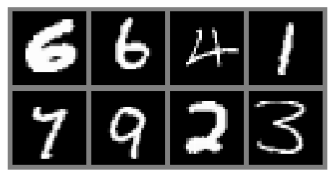

In [4]:
def show_imgs(imgs):
    imgs = jax.device_get(imgs)
    if isinstance(imgs, (list, tuple)):
        imgs = np.stack(imgs, axis=0)
    num_imgs = imgs.shape[0]
    if num_imgs < 4 or num_imgs % 4 == 0:
        nrow = min(num_imgs, 4)
        ncol = int(math.ceil(num_imgs/nrow))
    else:
        nrow = num_imgs
        ncol = 1
    imgs = np.pad(imgs, pad_width=[(0,0), (1,1), (1,1), (0,0)], constant_values=128)
    imgs = np.reshape(imgs, (nrow, ncol, *imgs.shape[1:]))
    imgs = np.transpose(imgs, (1, 2, 0, 3, 4))
    imgs = np.reshape(imgs, (imgs.shape[0]*imgs.shape[1], imgs.shape[2]*imgs.shape[3], -1))
    imgs = np.pad(imgs, pad_width=[(1,1), (1,1), (0,0)], constant_values=128)
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(imgs, interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

## Masked autoregressive convolutions

The core module of PixelCNN is its masked convolutions. In contrast to language models, we don't apply an LSTM on each pixel one-by-one. This would be inefficient because images are grids instead of sequences. Thus, it is better to rely on convolutions that have shown great success in deep CNN classification models.

Nevertheless, we cannot just apply standard convolutions without any changes.
Remember that during training of autoregressive models, we want to use teacher forcing which both helps the model training, and significantly reduces the time needed for training. For image modeling, teacher forcing is implemented by using a training image as input to the model, and we want to obtain as output the prediction for each pixel based on *only* its predecessors.
Thus, we need to ensure that the prediction for a specific pixel can only be influenced by its predecessors and not by its own value or any "future" pixels.
For this, we apply convolutions with a mask. 

Which mask we use depends on the ordering of pixels we decide on, i.e. which is the first pixel we predict, which is the second one, etc.
The most commonly used ordering is to denote the upper left pixel as the start pixel, and sort the pixels row by row, as shown in the visualization at the top of the tutorial.
Thus, the second pixel is on the right of the first one (first row, second column), and once we reach the end of the row, we start in the second row, first column.
If we now want to apply this to our convolutions, we need to ensure that the prediction of pixel 1 is not influenced by its own "true" input, and all pixels on its right and in any lower row. In convolutions, this means that we want to set those entries of the weight matrix to zero that take pixels on the right and below into account. As an example for a 5x5 kernel, see a mask below (figure credit - [Aaron van den Oord](https://arxiv.org/pdf/1606.05328.pdf)):

<center width="100%" style="padding: 10px"><img src="../../tutorial12/masked_convolution.svg" width="150px"></center>

Before looking into the application of masked convolutions in PixelCNN in detail, let's first implement a module that allows us to apply an arbitrary mask to a convolution:

In [5]:
class MaskedConvolution(nn.Module):
    c_out : int
    mask : np.ndarray
    dilation : int = 1
        
    @nn.compact
    def __call__(self, x):
        # Flax's convolution module already supports masking
        # The mask must be the same size as kernel 
        # => extend over input and output feature channels
        if len(self.mask.shape) == 2:
            mask_ext = self.mask[...,None,None]
            mask_ext = jnp.tile(mask_ext, (1, 1, x.shape[-1], self.c_out))
        else:
            mask_ext = self.mask
        # Convolution with masking
        x = nn.Conv(features=self.c_out,
                    kernel_size=self.mask.shape[:2],
                    kernel_dilation=self.dilation,
                    mask=mask_ext)(x)
        return x

### Vertical and horizontal convolution stacks

To build our own autoregressive image model, we could simply stack a few masked convolutions on top of each other.
This was actually the case for the original PixelCNN model, discussed in the paper [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf), but this leads to a considerable issue.
When sequentially applying a couple of masked convolutions, the receptive field of a pixel show to have a "blind spot" on the right upper side, as shown in the figure below (figure credit - [Aaron van den Oord et al.](https://arxiv.org/pdf/1606.05328.pdf)): 

<center width="100%" style="padding: 10px"><img src="../../tutorial12/pixelcnn_blind_spot.svg" width="275px"></center>

Although a pixel should be able to take into account all other pixels above and left of it, a stack of masked convolutions does not allow us to look to the upper pixels on the right. This is because the features of the pixels above, which we use for convolution, do not contain any information of the pixels on the right of the same row. If they would, we would be "cheating" and actually looking into the future. To overcome this issue, van den Oord et. al [2] proposed to split the convolutions into a vertical and a horizontal stack. The vertical stack looks at all pixels above the current one, while the horizontal takes into account all on the left. While keeping both of them separate, we can actually look at the pixels on the right with the vertical stack without breaking any of our assumptions. The two convolutions are also shown in the figure above.

Let us implement them here as follows:

In [6]:
class VerticalStackConvolution(nn.Module):
    c_out : int
    kernel_size : int
    mask_center : bool = False
    dilation : int = 1
        
    def setup(self):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = np.ones((self.kernel_size, self.kernel_size), dtype=np.float32)
        mask[self.kernel_size//2+1:,:] = 0
        # For the very first convolution, we will also mask the center row
        if self.mask_center:
            mask[self.kernel_size//2,:] = 0
        # Our convolution module
        self.conv = MaskedConvolution(c_out=self.c_out,
                                      mask=mask,
                                      dilation=self.dilation)
        
    def __call__(self, x):
        return self.conv(x)
        

class HorizontalStackConvolution(nn.Module):
    c_out : int
    kernel_size : int
    mask_center : bool = False
    dilation : int = 1
        
    def setup(self):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = np.ones((1, self.kernel_size), dtype=np.float32)
        mask[0,self.kernel_size//2+1:] = 0
        # For the very first convolution, we will also mask the center pixel
        if self.mask_center:
            mask[0,self.kernel_size//2] = 0
        # Our convolution module
        self.conv = MaskedConvolution(c_out=self.c_out,
                                      mask=mask,
                                      dilation=self.dilation)
        
    def __call__(self, x):
        return self.conv(x)

Note that we have an input argument called `mask_center`. Remember that the input to the model is the actual input image. Hence, the very first convolution we apply cannot use the center pixel as input, but must be masked. All consecutive convolutions, however, should use the center pixel as we otherwise lose the features of the previous layer. Hence, the input argument `mask_center` is True for the very first convolutions, and False for all others.

### Visualizing the receptive field

To validate our implementation of masked convolutions, we can visualize the receptive field we obtain with such convolutions. 
We should see that with increasing number of convolutional layers, the receptive field grows in both vertical and horizontal direction, without the issue of a blind spot.
The receptive field can be empirically measured by backpropagating an arbitrary loss for the output features of a speicifc pixel with respect to the input.
We implement this idea below, and visualize the receptive field below.

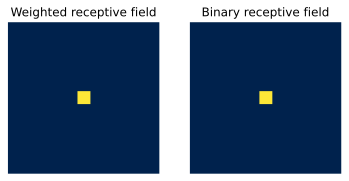

In [7]:
inp_img = np.zeros((1, 11, 11, 1), dtype=np.float32)

def show_center_recep_field(img, apply_fn):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    grad_fn = jax.grad(lambda inp: apply_fn(inp)[0,inp.shape[1]//2,inp.shape[2]//2].sum()) # L1 loss for simplicity
    img_grads = jnp.abs(grad_fn(img))
    img_grads = jax.device_get(img_grads)
    
    # Plot receptive field
    img = img_grads[0,...,0]
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0]) 
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

show_center_recep_field(inp_img, lambda x: x)

Let's first visualize the receptive field of a horizontal convolution without the center pixel. We use a small, arbitrary input image ($11\times 11$ pixels), and calculate the loss for the center pixel. For simplicity, we initialize all weights with 1 and the bias with 0, and use a single channel. This is sufficient for our visualization purposes.

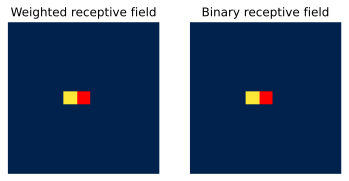

In [8]:
horiz_conv = HorizontalStackConvolution(c_out=1, kernel_size=3, mask_center=True)
# Create parameters with kernel filled with 1, and bias filled with zeros.
# As alternative, one could overwrite kernel init of 
init_params = lambda params: jax.tree_map(lambda x: jnp.full(x.shape, (0 if len(x.shape) == 1 else 1), dtype=x.dtype), params)
horiz_params = horiz_conv.init(random.PRNGKey(0), inp_img)
horiz_params = init_params(horiz_params)
# Apply horizontal convolution
horiz_conv = horiz_conv.bind(horiz_params)
show_center_recep_field(inp_img, lambda inp: horiz_conv(inp))

The receptive field is shown in yellow, the center pixel in red, and all other pixels outside of the receptive field are dark blue. As expected, the receptive field of a single horizontal convolution with the center pixel masked and a $3\times3$ kernel is only the pixel on the left. If we use a larger kernel size, more pixels would be taken into account on the left.

Next, let's take a look at the vertical convolution:

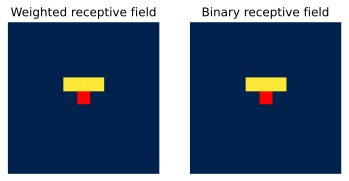

In [9]:
vert_conv = VerticalStackConvolution(c_out=1, kernel_size=3, mask_center=True)
vert_params = vert_conv.init(random.PRNGKey(0), inp_img)
vert_params = init_params(vert_params)
vert_conv = vert_conv.bind(vert_params)
show_center_recep_field(inp_img, lambda inp: vert_conv(inp))

The vertical convolution takes all pixels above into account. Combining these two, we get the L-shaped receptive field of the original masked convolution:

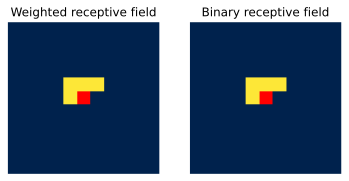

In [10]:
show_center_recep_field(inp_img, lambda inp: vert_conv(inp) + horiz_conv(inp))

If we stack multiple horizontal and vertical convolutions, we need to take two aspects into account:

1. The center should not be masked anymore for the following convolutions as the features at the pixel's position are already independent of its actual value. If it is hard to imagine why we can do this, just change the value below to `mask_center=True` and see what happens.
2. The vertical convolution is not allowed to work on features from the horizontal convolution. In the feature map of the horizontal convolutions, a pixel contains information about all of the "true" pixels on the left. If we apply a vertical convolution which also uses features from the right, we effectively expand our receptive field to the true input which we want to prevent. Thus, the feature maps can only be merged for the horizontal convolution.

Using this, we can stack the convolutions in the following way. We have two feature streams: one for the vertical stack, and one for the horizontal stack. The horizontal convolutions can operate on the joint features of the previous horizontals and vertical convolutions, while the vertical stack only takes its own previous features as input. For a quick implementation, we can therefore sum the horizontal and vertical output features at each layer, and use those as final output features to calculate the loss on. An implementation of up to 4 consecutive layers is shown below. Note that we reuse the features from the other convolutions with `mask_center=True` from above.

Layer 2


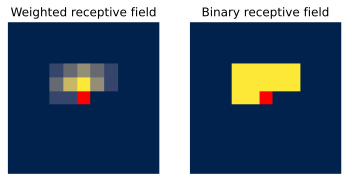

Layer 3


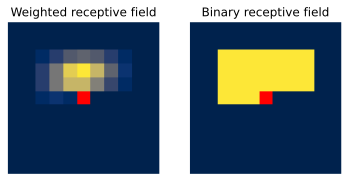

Layer 4


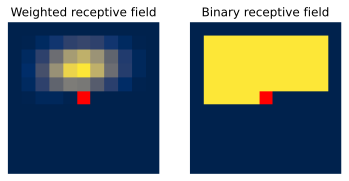

Layer 5


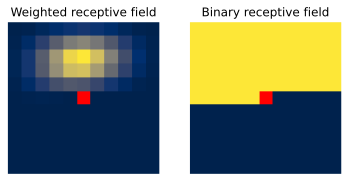

In [11]:
# Convolutions with mask_center=False, no need for new parameters since 
horiz_noc_conv = HorizontalStackConvolution(c_out=1, kernel_size=3, mask_center=False)
vert_noc_conv = VerticalStackConvolution(c_out=1, kernel_size=3, mask_center=False)
horiz_noc_conv = horiz_noc_conv.bind(horiz_params)
vert_noc_conv = vert_noc_conv.bind(vert_params)

# We reuse our convolutions for the several layers with same parameters just for visualization.
def num_layer_network(inp, num_layers):
    vert_img = vert_conv(inp)
    horiz_img = horiz_conv(inp) + vert_img
    for _ in range(num_layers-1):
        vert_img = vert_noc_conv(vert_img)
        horiz_img = horiz_noc_conv(horiz_img) + vert_img
    return horiz_img, vert_img

for layer_count in range(2, 6):
    print(f"Layer {layer_count}")
    show_center_recep_field(inp_img, lambda inp: num_layer_network(inp, layer_count)[0])

The receptive field above it visualized for the horizontal stack, which includes the features of the vertical convolutions. It grows over layers without any blind spot as we had before. The difference between "weighted" and "binary" receptive field is that for the latter, we check whether there are any gradients flowing back to this pixel. This indicates that the center pixel indeed can use information from this pixel. Nevertheless, due to the convolution weights, some pixels have a stronger effect on the prediction than others. This is visualized in the weighted receptive field by plotting the gradient magnitude for each pixel instead of a binary yes/no.


Another receptive field we can check is the one for the vertical stack as the one above is for the horizontal stack. Let's visualize it below:

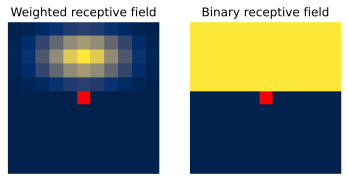

In [12]:
show_center_recep_field(inp_img, lambda inp: num_layer_network(inp, 5)[1])

As we have discussed before, the vertical stack only looks at pixels above the one we want to predict.
Hence, we can validate that our implementation works as we initially expected it to.

## Gated PixelCNN

In the next step, we will use the masked convolutions to build a full autoregressive model, called Gated PixelCNN. The difference between the original PixelCNN and Gated PixelCNN is the use of separate horizontal and vertical stacks. However, in literature, you often see that people refer to the Gated PixelCNN simply as "PixelCNN". Hence, in the following, if we say "PixelCNN", we usually mean the gated version. What "Gated" refers to in the model name is explained next. 

### Gated Convolutions

For visualizing the receptive field, we assumed a very simplified stack of vertical and horizontal convolutions. 
Obviously, there are more sophisticated ways of doing it, and PixelCNN uses gated convolutions for this.
Specifically, the Gated Convolution block in PixelCNN looks as follows (figure credit - [Aaron van den Oord et al.](https://arxiv.org/pdf/1606.05328.pdf)):

<center width="100%"><img src="../../tutorial12/PixelCNN_GatedConv.svg" width="700px" style="padding: 15px"/></center>

The left path is the vertical stack (the $N\times N$ convolution is masked correspondingly), and the right path is the horizontal stack. Gated convolutions are implemented by having a twice as large output channel size, and combine them by a element-wise multiplication of $\tanh$ and a sigmoid. For a linear layer, we can express a gated activation unit as follows:

$$\mathbf{y} = \tanh\left(\mathbf{W}_{f}\mathbf{x}\right)\odot\sigma\left(\mathbf{W}_{g}\mathbf{x}\right)$$

For simplicity, biases have been neglected and the linear layer split into two part, $\mathbf{W}_{f}$ and $\mathbf{W}_{g}$. This concept resembles the input and modulation gate in an LSTM, and has been used in many other architectures as well. The main motivation behind this gated activation is that it might allow to model more complex interactions and simplifies learning. But as in any other architecture, this is mostly a design choice and can be considered a hyperparameters.

Besides the gated convolutions, we also see that the horizontal stack uses a residual connection while the vertical stack does not. This is because we use the output of the horizontal stack for prediction. Each convolution in the vertical stack also receives a strong gradient signal as it is only two $1\times 1$ convolutions away from the residual connection, and does not require another residual connection to all its earleri layers.

The implementation in Flax is fairly straight forward for this block, because the visualization above gives us a computation graph to follow:

In [13]:
class GatedMaskedConv(nn.Module):
    dilation : int = 1
    
    @nn.compact
    def __call__(self, v_stack, h_stack):
        c_in = v_stack.shape[-1]
        
        # Layers (depend on input shape)
        conv_vert = VerticalStackConvolution(c_out=2*c_in, 
                                             kernel_size=3, 
                                             mask_center=False, 
                                             dilation=self.dilation)
        conv_horiz = HorizontalStackConvolution(c_out=2*c_in, 
                                                kernel_size=3, 
                                                mask_center=False,
                                                dilation=self.dilation)
        conv_vert_to_horiz = nn.Conv(2*c_in, 
                                     kernel_size=(1, 1))
        conv_horiz_1x1 = nn.Conv(c_in, 
                                 kernel_size=(1, 1))
        
        # Vertical stack (left)
        v_stack_feat = conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.split(2, axis=-1)
        v_stack_out = v_val * v_gate # nn.tanh(v_val) * nn.sigmoid(v_gate)
        
        # Horizontal stack (right)
        h_stack_feat = conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.split(2, axis=-1)
        h_stack_feat = nn.tanh(h_val) * nn.sigmoid(h_gate)
        h_stack_out = conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack
        
        return v_stack_out, h_stack_out

### Building the model

Using the gated convolutions, we can now build our PixelCNN model. 
The architecture consists of multiple stacked GatedMaskedConv blocks, where we add an additional dilation factor to a few convolutions. 
This is used to increase the receptive field of the model and allows to take a larger context into accout during generation. 
As a reminder, dilation on a convolution works looks as follows (figure credit - [Vincent Dumoulin and Francesco Visin](https://arxiv.org/pdf/1603.07285.pdf)):

<center width="100%"><img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif" width="250px"></center>

Note that the smaller output size is only because the animation assumes no padding. In our implementation, we will pad the input image correspondingly. Alternatively to dilated convolutions, we could downsample the input and use a encoder-decoder architecture as in PixelCNN++ [3]. This is especially beneficial if we want to build a very deep autoregressive model. Nonetheless, as we seek to train a reasonably small model, dilated convolutions are the more efficient option to use here. 

Below, we implement the PixelCNN model as a Flax module. Besides the stack of gated convolutions, we also have the initial horizontal and vertical convolutions which mask the center pixel, and a final $1\times 1$ convolution which maps the output features to class predictions. To determine the likelihood of a batch of images, we first create our initial features using the masked horizontal and vertical input convolution. Next, we forward the features through the stack of gated convolutions. Finally, we take the output features of the horizontal stack, and apply the $1\times 1$ convolution for classification. We use the bits per dimension metric for the likelihood, similarly to [Tutorial 11](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial11/NF_image_modeling.html).

In [14]:
class PixelCNN(nn.Module):
    c_in : int
    c_hidden : int
    
    def setup(self):
        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(self.c_hidden, kernel_size=3, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(self.c_hidden, kernel_size=3, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = [
            GatedMaskedConv(),
            GatedMaskedConv(dilation=2),
            GatedMaskedConv(),
            GatedMaskedConv(dilation=4),
            GatedMaskedConv(),
            GatedMaskedConv(dilation=2),
            GatedMaskedConv()
        ]
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv(self.c_in * 256, kernel_size=(1, 1))
        
    def __call__(self, x):
        # Forward pass with bpd likelihood calculation
        logits = self.pred_logits(x)
        labels = jax.nn.one_hot(x, num_classes=logits.shape[-1])
        nll = optax.softmax_cross_entropy(logits, labels)
        bpd = nll.mean() * np.log2(np.exp(1))
        return bpd
    
    def pred_logits(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.astype(jnp.float32) / 255.0) * 2 - 1 
        
        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(nn.elu(h_stack))
        
        # Output dimensions: [Batch, Height, Width, Channels, Classes]
        out = out.reshape(out.shape[0], out.shape[1], out.shape[2], out.shape[3]//256, 256)
        return out
        
    def sample(self, img_shape, rng, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill 
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = jnp.zeros(img_shape, dtype=jnp.int32) - 1
        # We jit a prediction step. One could jit the whole loop, but this
        # is expensive to compile and only worth for a lot of sampling calls.
        get_logits = jax.jit(lambda inp: self.pred_logits(inp))
        # Generation loop
        for h in tqdm(range(img_shape[1]), leave=False):
            for w in range(img_shape[2]):
                for c in range(img_shape[3]):
                    # Skip if not to be filled (-1)
                    if (img[:,h,w,c] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    logits = get_logits(img) 
                    logits = logits[:,h,w,c,:]
                    rng, pix_rng = random.split(rng)
                    img = img.at[:,h,w,c].set(random.categorical(pix_rng, logits, axis=-1))
        return img

To sample from the autoregressive model, we need to iterate over all dimensions of the input. We start with an empty image, and fill the pixels one by one, starting from the upper left corner. Note that as for predicting $x_i$, all pixels below it have no influence on the prediction. Hence, we can cut the image in height without changing the prediction while increasing efficiency. Nevertheless, all the loops in the sampling function already show that it will take us quite some time to sample. A lot of computation could be reused across loop iterations as those the features on the already predicted pixels will not change over iterations. Nevertheless, this takes quite some effort to implement, and is often not done in implementations because in the end, autoregressive sampling remains sequential and slow. Hence, we settle with the default implementation here.

Before training the model, we can check the full receptive field of the model on an MNIST image of size $28\times 28$:

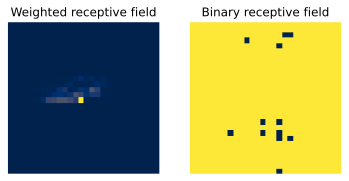

In [15]:
model = PixelCNN(c_in=1, c_hidden=64)
inp = random.randint(random.PRNGKey(1), (1,28,28,1), 0, 255).astype(jnp.float32)
params = model.init(random.PRNGKey(0), inp)
show_center_recep_field(inp, lambda x: model.bind(params).pred_logits(x)[...,0,0])

Wait, the receptive field for a single pixel is suddenly the whole image?! Did we make a mistake in our implementation? Unlikely. As it turns out, masked convolutions in Flax show a behavior that leaks gradients through the input mask for larger channel numbers. Note that these gradients for the masked elements is often smaller by a factor of $10^{-6}$. What about the gradients for the parameters? Let's check:

In [16]:
grads = jax.grad(lambda p: model.apply(p, inp))(params)
# Gradients of the weights in the first h-stack convolution 
# for the first feature map:
grads['params']['conv_hstack']['conv']['Conv_0']['kernel'][:,:,:,0]

DeviceArray([[[-0.00850878],
              [ 0.        ],
              [ 0.        ]]], dtype=float32)

The last two entries indicate the gradients for the center and right pixel of the initial horizontal stack convolution. The gradients are zero, as we expected. So, the gradients for the weights are correct, only the gradients propagating through the feature layers has minor noise that we unintended. Nonetheless, this should be good enough for training.

<div class="alert alert-info">

**Note:** If you know the details behind why the gradients leak through the mask, I would appreciate any hint on the corresponding [GitHub disccusion](https://github.com/google/flax/discussions/2387) on Flax.
    
</div>

Despite a large receptive field, keep in mind that this is the "theoretical" receptive field and not necessarily the [effective receptive field](https://arxiv.org/pdf/1701.04128.pdf), which is usually much smaller. 
For a stronger model, we should therefore try to increase the receptive field even further. Especially, for the pixel on the bottom right, the very last pixel, we would be allowed to take into account the whole image. However, our current receptive field only spans across 1/4 of the image. An encoder-decoder architecture can help with this, but it also shows that we require a much deeper, more complex network in autoregressive models than in VAEs or energy-based models.

### Training loop

To train the model, we again can rely on building ourselves a small trainer module that gives us a full training loop, including loading and saving the model.

In [17]:
class TrainerModule:

    def __init__(self,
                 c_in : int,
                 c_hidden : int,
                 exmp_imgs : Any,
                 lr : float = 1e-3,
                 seed : int = 42):
        """
        Module for summarizing all training functionalities for the PixelCNN.
        """
        super().__init__()
        self.lr = lr
        self.seed = seed
        self.model_name = 'PixelCNN'
        # Create empty model. Note: no parameters yet
        self.model = PixelCNN(c_in=c_in, c_hidden=c_hidden)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Training function
        def train_step(state, batch):
            imgs, _ = batch
            loss_fn = lambda params: state.apply_fn(params, imgs)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            return state, loss
        # Eval function
        def eval_step(state, batch):
            imgs, _ = batch
            loss = state.apply_fn(state.params, imgs)
            return loss
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        init_rng = random.PRNGKey(self.seed)
        params = self.model.init(init_rng, exmp_imgs)
        self.state = train_state.TrainState(step=0,
                                            apply_fn=self.model.apply,
                                            params=params,
                                            tx=None,
                                            opt_state=None)

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=100,
            decay_steps=num_epochs * num_steps_per_epoch,
            end_value=1e-2*self.lr
        )
        optimizer = optax.chain(
            optax.clip(0.1),  # Clip gradients at 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.state.apply_fn,
                                                   params=self.state.params,
                                                   tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval bpd score.
        best_eval = 1e6
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 1 == 0:
                eval_bpd = self.eval_model(val_loader)
                self.logger.add_scalar('val/bpd', eval_bpd, global_step=epoch_idx)
                if eval_bpd <= best_eval:
                    best_eval = eval_bpd
                    self.save_model(step=epoch_idx)
            self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg bpd
        avg_loss = 0
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss = self.train_step(self.state, batch)
            avg_loss += loss
        avg_loss /= len(train_loader)
        self.logger.add_scalar('train/bpd', avg_loss.item(), global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg bpd
        avg_bpd, count = 0, 0
        for batch in data_loader:
            bpd = self.eval_step(self.state, batch)
            avg_bpd += bpd * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_bpd = (avg_bpd / count).item()
        return eval_bpd

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        self.state = train_state.TrainState.create(apply_fn=self.state.apply_fn,
                                                   params=state_dict,
                                                   tx=self.state.tx if self.state else optax.sgd(0.1)   # Default optimizer
                                                  )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

Finally, let's write a training function that loads the pretrained model if it exists.

In [18]:
def train_model(max_epochs=150, **model_args):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(exmp_imgs=next(iter(train_loader))[0],
                            **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    val_bpd = trainer.eval_model(val_loader)
    test_bpd = trainer.eval_model(test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind(trainer.state.params)
    return trainer, {'val_bpd': val_bpd, 'test_bpd': test_bpd}

Training the model is time consuming and we recommend using the provided pre-trained model for going through this notebook. However, feel free to play around with the hyperparameter like number of layers etc. if you want to get a feeling for those. 

When calling the training function with a pre-trained model, we automatically load it and print its test performance:

In [19]:
trainer, result = train_model(max_epochs=1, c_in=1, c_hidden=64)
print(f'Test bpd: {result["test_bpd"]:4.3f}')

  0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Test bpd: 1.248


With a test performance of **!!!TODO!!!** 0.809bpd, the PixelCNN significantly outperforms the normalizing flows we have seen in [Tutorial 11](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial11/NF_image_modeling.html). 
Considering image modeling as an autoregressive problem simplifies the learning process as predicting one pixel given the ground truth of all others is much easier than predicting all pixels at once.
In addition, PixelCNN can explicitly predict the pixel values by a discrete softmax while Normalizing Flows have to learn transformations in continuous latent space.
These two aspects allow the PixelCNN to achieve a notably better performance. 

To fully compare the models, let's also measure the number of parameters of the PixelCNN:

In [20]:
num_params = sum([np.prod(p.shape) for p in jax.tree_leaves(trainer.state.params)])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


Compared to the multi-scale normalizing flows, the PixelCNN has considerably less parameters. 
Of course, the number of parameters depend on our hyperparameter choices.
Nevertheless, in general, it can be said that autoregressive models require considerably less parameters than normalizing flows to reach good performance, based on the reasons stated above. Still, autoregressive models are much slower in sampling than normalizing flows, which limits their possible applications.

## Sampling

One way of qualitatively analysing generative models is by looking at the actual samples.
Let's therefore use our sampling function to generate a few digits:

  0%|          | 0/28 [00:00<?, ?it/s]

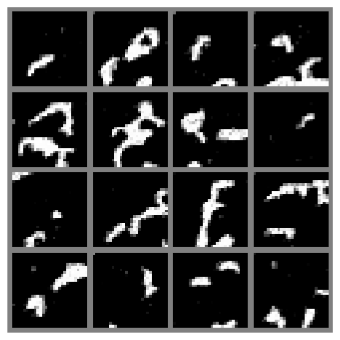

In [21]:
samples = trainer.model_bd.sample(img_shape=(16,28,28,1), rng=random.PRNGKey(42))
show_imgs(samples)

Most of the samples can be identified as digits, and overall we achieve a better quality than we had in normalizing flows.
This goes along with the lower likelihood we achieved with autoregressive models.
Nevertheless, we also see that there is still place for improvement as a considerable amount of samples cannot be identified (for example the first row). Deeper autoregressive models are expected to achieve better quality, as they can take more context into account for generating the pixels.

The trained model itself is not restricted to any specific image size. However, what happens if we actually sample a larger image than we had seen in our training dataset? Let's try below to sample images of size $64\times64$ instead of $28\times28$:

  0%|          | 0/64 [00:00<?, ?it/s]

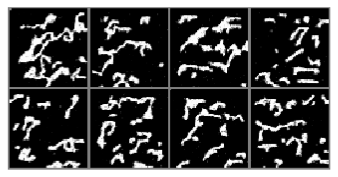

In [29]:
samples = trainer.model_bd.sample(img_shape=(8,64,64,1), rng=random.PRNGKey(42))
show_imgs(samples)

The larger images show that changing the size of the image during testing confuses the model and generates abstract figures (you can sometimes spot a digit in the upper left corner).
In addition, sampling for images of 64x64 pixels take up to a minute on a GPU. 
Clearly, autoregressive models cannot be scaled to large images without changing the sampling procedure such as with [forecasting](https://arxiv.org/abs/2002.09928). 
Our implementation is also not the most efficient as many computations can be stored and reused throughout the sampling process.
Nevertheless, the sampling procedure stays sequential which is inherently slower than parallel generation like done in normalizing flows.

### Autocompletion

One common application done with autoregressive models is auto-completing an image. As autoregressive models predict pixels one by one, we can set the first $N$ pixels to predefined values and check how the model completes the image. For implementing this, we just need to skip the iterations in the sampling loop that already have a value unequals -1. See above in our Flax module for the specific implementation. In the cell below, we randomly take three images from the training set, mask about the lower half of the image, and let the model autocomplete it. To see the diversity of samples, we do this 12 times for each image:

Original image and input image to sampling:


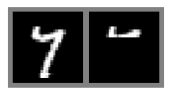

  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


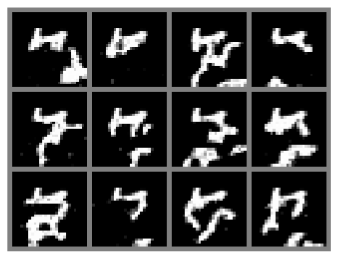

Original image and input image to sampling:


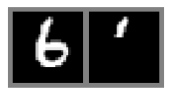

  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


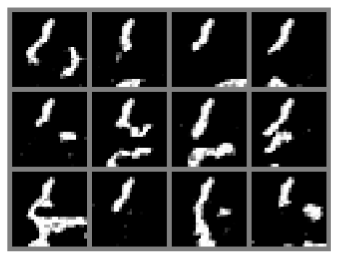

Original image and input image to sampling:


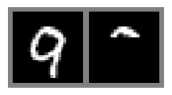

  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


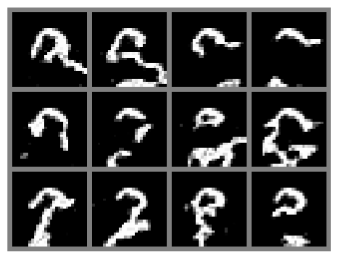

In [23]:
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = np.copy(img)
    img_init[10:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = np.repeat(img_init[None], 12, axis=0)
    img_init = jax.device_put(img_init)
    img_generated = trainer.model_bd.sample(img_init.shape, 
                                            rng=random.PRNGKey(42),
                                            img=img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)

for i in range(1,4):
    img = train_set[i][0]
    autocomplete_image(img)

For the first two digits (7 and 6), we see that the 12 samples all result in a shape which resemble the original digit. Nevertheless, there are some style difference in writing the 7, and some deformed sixes in the samples. When autocompleting the 9 below, we see that the model can fit multiple digits to it. We obtain diverse samples from 0, 3, 8 and 9. This shows that despite having no latent space, we can still obtain diverse samples from an autoregressive model.

### Visualization of the predictive distribution (softmax)

Autoregressive models use a softmax over 256 values to predict the next pixel.
This gives the model a large flexibility as the probabilities for each pixel value can be learned independently if necessary.
However, the values are actually not independent because the values 32 and 33 are much closer than 32 and 255. 
In the following, we visualize the softmax distribution that the model predicts to gain insights how it has learned the relationships of close-by pixels.

To do this, we first run the model on a batch of images and store the output softmax distributions:

In [24]:
det_loader = data.DataLoader(train_set, batch_size=128, shuffle=False, drop_last=False, collate_fn=numpy_collate)
imgs,_ = next(iter(det_loader))

out = trainer.model_bd.pred_logits(imgs)
out = nn.softmax(out, axis=-1)
mean_out = jax.device_get(out.mean(axis=[0,1,2,3]))
out = jax.device_get(out)

Before diving into the model, let's visualize the distribution of the pixel values in the whole dataset:

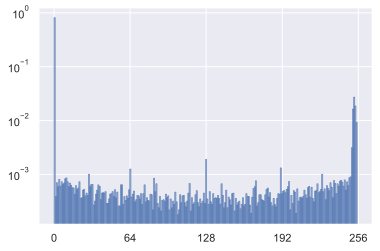

In [25]:
sns.set()
plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
plt.hist(imgs.reshape(-1), bins=256, density=True, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

As we would expect from the seen images, the pixel value 0 (black) is the dominant value, followed by a batch of values between 250 and 255. 
Note that we use a log scale on the y-axis due to the big imbalance in the dataset.
Interestingly, the pixel values 64, 128 and 191 also stand out which is likely due to the quantization used during the creation of the dataset. For RGB images, we would also see two peaks around 0 and 255, but the values in between would be much more frequent than in MNIST (see Figure 1 in the [PixelCNN++](https://arxiv.org/pdf/1701.05517.pdf) for a visualization on CIFAR10).

Next, we can visualize the distribution our model predicts (in average):

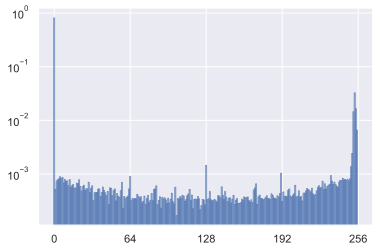

In [26]:
plt.bar(np.arange(mean_out.shape[0]), mean_out, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

This distribution is very close to the actual dataset distribution. This is in general a good sign, but we can see a slightly smoother histogram than above. 

Finally, to take a closer look at learned value relations, we can visualize the distribution for individual pixel predictions to get a better intuition. For this, we pick 4 random images and pixels, and visualize their distribution below:

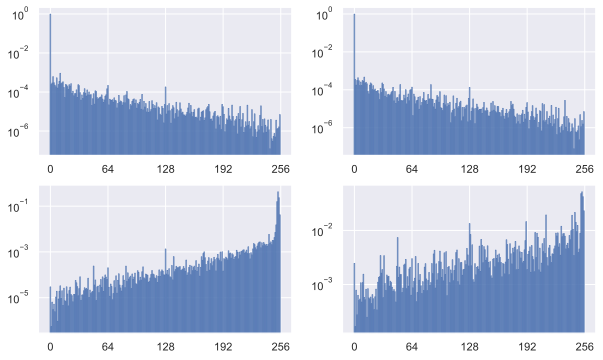

In [27]:
fig, ax = plt.subplots(2,2, figsize=(10,6))
for i in range(4):
    ax_sub = ax[i//2][i%2]
    ax_sub.bar(np.arange(out.shape[-1], dtype=np.int32), out[i+4,14,14,0], **plot_args)
    ax_sub.set_yscale("log")
    ax_sub.set_xticks([0,64,128,192,256])
plt.show()
plt.close()

Overall we see a very diverse set of distributions, with a usual peak for 0 and close to 1. However, the distributions in the first row show a potentially undesirable behavior. For instance, the value 242 has a 1000x lower likelihood than 243 although they are extremely close and can often not be distinguished. This shows that the model might have not generlized well over pixel values. The better solution to this problem is to use discrete logitics mixtures instead of a softmax distribution. A discrete logistic distribution can be imagined as discretized, binned Gaussians. Using a mixture of discrete logistics instead of a softmax introduces an inductive bias to the model to assign close-by values similar likelihoods. We can visualize a discrete logistic below:

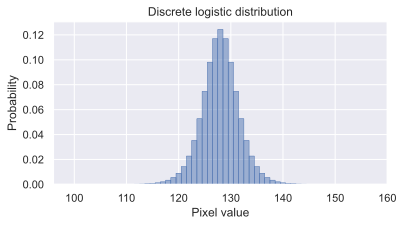

In [28]:
mu = np.array([128])
sigma = np.array([2.0])

def discrete_logistic(x, mu, sigma):
    return nn.sigmoid((x+0.5-mu)/sigma) - nn.sigmoid((x-0.5-mu)/sigma)

x = np.arange(256)
p = discrete_logistic(x, mu, sigma)

# Visualization
plt.figure(figsize=(6,3))
plt.bar(x, p, **plot_args)
plt.xlim(96,160)
plt.title("Discrete logistic distribution")
plt.xlabel("Pixel value")
plt.ylabel("Probability")
plt.show()
plt.close()

Instead of the softmax, the model would output mean and standard deviations for the $K$ logistics we use in the mixture. This is one of the improvements in autoregressive models that PixelCNN++ [3] has introduced compared to the original PixelCNN.

## Conclusion

In this tutorial, we have looked at autoregressive image modeling, and implemented the PixelCNN architecture. With the usage of masked convolutions, we are able to apply a convolutional network in which a pixel is only influenced by all its predecessors. Separating the masked convolution into a horizontal and vertical stack allowed us to remove the known blind spot on the right upper row of a pixel. In experiments, autoregressive models outperformed normalizing flows in terms of bits per dimension, but are much slower to sample from. Improvements, that we have not implemented ourselves here, are discrete logistic mixtures, a downsampling architecture, and changing the pixel order in a diagonal fashion (see PixelSNAIL). Overall, autoregressive models are another, strong family of generative models, which however are mostly used in sequence tasks because of their linear scaling in sampling time than quadratic as on images.

## References
[1] van den Oord, A., et al. "Pixel Recurrent Neural Networks." arXiv preprint arXiv:1601.06759 (2016). [Link](https://arxiv.org/abs/1601.06759)

[2] van den Oord, A., et al. "Conditional Image Generation with PixelCNN Decoders." In Advances in Neural Information Processing Systems 29, pp. 4790–4798 (2016). [Link](http://papers.nips.cc/paper/6527-conditional-image-generation-with-pixelcnn-decoders.pdf)

[3] Salimans, Tim, et al. "PixelCNN++: Improving the PixelCNN with Discretized Logistic Mixture Likelihood and Other Modifications." arXiv preprint arXiv:1701.05517 (2017). [Link](https://arxiv.org/abs/1701.05517)

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---